# Import python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define Antoine equations

In [2]:
def T1_sat(p):
  return 2945.47/(14.2724 - np.log(p)) - 224.00
def T2_sat(p):
  return 2972.64/(14.2043 - np.log(p)) - 209.00
def P1_sat(t):
  return np.exp(14.2724-2945.47/(t+224.0))
def P2_sat(t):
  return np.exp(14.2043-2972.64/(t+209.0))

# Calculate single component vapor pressures

In [3]:
p = 70.0 # kPa
print("t1_sat({}kPa) = {}\u00B0C and t2_sat({}kPa) = {}\u00B0C".format(p, np.round(T1_sat(p), 2), p, np.round(T2_sat(p), 2)))

t1_sat(70.0kPa) = 69.84°C and t2_sat(70.0kPa) = 89.58°C


In [4]:
def X1(p, t):
  return (p - P2_sat(t))/(P1_sat(t) - P2_sat(t))
def Y1(p, t):
  return X1(p, t)*P1_sat(t)/p

# Construct T-x-y table

In [5]:
ts = np.array([T2_sat(p), 86., 82., 78., 74., T1_sat(p)])
x1s = X1(p, ts)
y1s = Y1(p, ts)
table = {'x1': np.round(x1s, 4), 'y1': np.round(y1s, 4), 'T/\u00B0C': np.round(ts, 2)}
df = pd.DataFrame.from_dict(table)
print(df)

       x1      y1   T/°C
0  0.0000  0.0000  89.58
1  0.1424  0.2401  86.00
2  0.3184  0.4742  82.00
3  0.5156  0.6759  78.00
4  0.7378  0.8484  74.00
5  1.0000  1.0000  69.84


# Construct T-x-y diagram

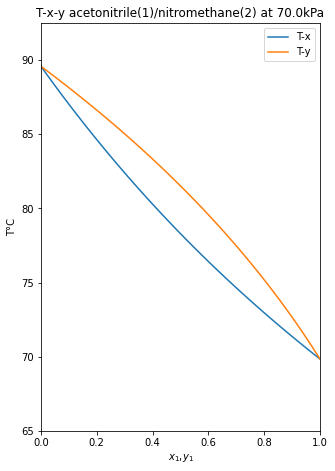

In [6]:
ts = np.arange(T1_sat(p), T2_sat(p)+0.5, 0.5)
plt.figure(figsize=(5, 7.5))
plt.plot(X1(p, ts), ts)
plt.plot(Y1(p, ts), ts)
plt.title("T-x-y acetonitrile(1)/nitromethane(2) at {}kPa".format(p))
plt.ylabel("T\u00B0C")
plt.xlabel("$x_1$,$y_1$")
plt.xlim(0.0, 1.0)
plt.ylim(65.0, 92.5)
plt.yticks(np.arange(65.,95.,5.))
plt.legend(['T-x', 'T-y'], loc=1)

# Define useful functions for BUBL T and DEW T calculations

In [7]:
def Alpha(t):
  lnalpha = 0.0681 - 2945.47/(t+224.) + 2972.64/(t+209.)
  return np.exp(lnalpha)
def P1_sat_from_alpha(y1, p, t):
  return p*(y1 + (1-y1)*Alpha(t))
def P2_sat_from_alpha(x1, p, t):
  return p/(x1*Alpha(t)+(1-x1))

# Define BUBL T function

In [8]:
def BUBL_T(x1, p):
  tol = 1e-2 # Define convergence criteria
  # Guess a temperature between the two saturation temperatures
  t_prev = 0.
  t_curr = (T2_sat(p) - T1_sat(p))*np.random.uniform() + T1_sat(p)
  # Iterate until convergence criteria is satisfied
  while(np.abs(t_curr-t_prev)>tol):
    # Step 1: Calculate alpha given current guess temperature
    # Step 2: Calculate P2_sat given system pressure, alpha, and x1
    P2_sat_curr = P2_sat_from_alpha(x1, p, t_curr)
    t_prev = t_curr
    # Step 3: Calculate temperature given P2_sat via Antoine equation
    t_curr = T2_sat(P2_sat_curr)
  # Calculate y1 given converged system temperature
  y1 = x1*P1_sat(t_curr)/p
  return t_curr, y1

# Perform BUBL T calculation

In [9]:
x1 = 0.6
T, y1 = BUBL_T(x1, p)
print("At x1 = {} and P = {} kPa, T = {} degC and y1 = {}".format(x1, p, np.round(T, 2), np.round(y1, 4)))

At x1 = 0.6 and P = 70.0 kPa, T = 76.42 degC and y1 = 0.7472


# Define DEW T function

In [10]:
def DEW_T(y1, p):
  # Define convergence criteria
  tol = 1e-2
  t_prev = 0.
  # Guess a temperature between the two saturation temperatures
  t_curr = (T2_sat(p) - T1_sat(p))*np.random.uniform() + T1_sat(p)
  # Iterate until convergence criteria is satisfied
  while(np.abs(t_curr-t_prev)>tol):
    # Step 1: calculate alpha given current guess temperature
    # Step 2: calculate P1_sat given y1, total pressure, and alpha
    P1_sat_curr = P1_sat_from_alpha(y1, p, t_curr)
    t_prev = t_curr
    # Step 3: calculate temperature given P1_sat via Antoine equation
    t_curr = T1_sat(P1_sat_curr)
  # Calculate x1 given system temperature
  x1 = y1*p/P1_sat_curr
  return t_curr, x1

# Perform DEW T calculation

In [11]:
y1 = 0.6
T, x1 = DEW_T(y1, p)
print("At y1 = {} and P = {}, T = {} degC and x1 = {}".format(y1, p, np.round(T, 2), np.round(x1, 4)))

At y1 = 0.6 and P = 70.0, T = 79.58 degC and x1 = 0.4351
